In [1]:
import sys
import os

notebook_path = os.getcwd() 
project_root = os.path.dirname(notebook_path)

if project_root not in sys.path:
    sys.path.insert(0, project_root)


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [3]:
import NN_models
import Filters
import utils
import Systems
from torch.utils.data import TensorDataset, DataLoader, random_split
from state_NN_models.StateKalmanNet import StateKalmanNet

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Používané zařízení: {device}")

Používané zařízení: cuda


In [5]:
h_true_nonlinear = lambda x: 0.5 * x
f_true_nonlinear = lambda x: 0.9 * x - 0.05 * x**3 

Q_true = torch.tensor([[0.1]])
R_true = torch.tensor([[0.1]])

Ex0_true = torch.tensor([[1.0]])
P0_true = torch.tensor([[0.5]])

sys_true = Systems.NonlinearSystem(f_true_nonlinear, h_true_nonlinear, Q_true, R_true, Ex0_true, P0_true)

#  Nepřesná dynamika (lineární aproximace nelineární funkce f)
f_model_nonlinear = lambda x: 0.9 * x 
h_model_nonlinear = h_true_nonlinear
# Nepřesná znalost šumu (podcenění Q)
Q_model = torch.tensor([[0.01]])
R_model = torch.tensor([[0.2]])
# Nepřesný počáteční odhad (pro EKF)
Ex0_model = torch.tensor([[0.5]])
P0_model = torch.tensor([[0.5]])

# Sestavení nepřesného modelu pro filtry
# Funkce h, R jsou pro jednoduchost stejné, ale f, Q, Ex0, P0 jsou jiné
sys_model = Systems.NonlinearSystem(f_model_nonlinear, h_model_nonlinear, Q_model, R_model, Ex0_model, P0_model)
# sys_model = Systems.NonlinearSystem(f_true_nonlinear, h_true_nonlinear, Q_true, R_true, Ex0_model, P0_model)

In [6]:
TRAIN_SEQ_LEN = 10      # Krátké sekvence pro stabilní trénink (TBPTT)
VALID_SEQ_LEN = 20      # Stejná délka pro konzistentní validaci
TEST_SEQ_LEN = 200      # Dlouhé sekvence pro testování generalizace

NUM_TRAIN_TRAJ = 5000   # Hodně trénovacích příkladů
NUM_VALID_TRAJ = 500    # Dostatek pro spolehlivou validaci
NUM_TEST_TRAJ = 100     # Pro robustní vyhodnocení

BATCH_SIZE = 16         # Dobrý kompromis

x_train, y_train = utils.generate_data(sys_true, num_trajectories=NUM_TRAIN_TRAJ, seq_len=TRAIN_SEQ_LEN)
x_val, y_val = utils.generate_data(sys_true, num_trajectories=NUM_VALID_TRAJ, seq_len=VALID_SEQ_LEN)
x_test, y_test = utils.generate_data(sys_true, num_trajectories=1, seq_len=TEST_SEQ_LEN)

train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [7]:
ekf = Filters.ExtendedKalmanFilter(sys_model)
y_test_seq = y_test.squeeze(0)
ekf_results = ekf.apply_filter(y_test_seq)
x_hat_ekf = ekf_results['x_filtered']
P_hat_ekf = ekf_results['P_filtered']

In [8]:
state_knet = StateKalmanNet(sys_model, device=device, hidden_size_multiplier=10).to(device)
utils.train_state_KalmanNet(
    model=state_knet, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    device=device, 
    epochs=150, 
    lr=1e-4,
    early_stopping_patience=15
)

/home/luky/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [5/150], Train Loss: 0.134215, Val Loss: 0.130931
Epoch [10/150], Train Loss: 0.130162, Val Loss: 0.129182
Epoch [15/150], Train Loss: 0.128926, Val Loss: 0.128602
Epoch [20/150], Train Loss: 0.128452, Val Loss: 0.128169
Epoch [25/150], Train Loss: 0.128227, Val Loss: 0.128150
Epoch [30/150], Train Loss: 0.128232, Val Loss: 0.128100
Epoch [35/150], Train Loss: 0.128117, Val Loss: 0.127973
Epoch [40/150], Train Loss: 0.128050, Val Loss: 0.127957
Epoch [45/150], Train Loss: 0.128049, Val Loss: 0.127929
Epoch [50/150], Train Loss: 0.127930, Val Loss: 0.127893
Epoch [55/150], Train Loss: 0.128041, Val Loss: 0.127878
Epoch [60/150], Train Loss: 0.128040, Val Loss: 0.127892
Epoch [65/150], Train Loss: 0.127985, Val Loss: 0.127901
Epoch [70/150], Train Loss: 0.127972, Val Loss: 0.127897

Early stopping spuštěno po 72 epochách.
Trénování dokončeno.
Načítám nejlepší model s validační chybou: 0.127874


StateKalmanNet(
  (dnn): DNN_KalmanNet(
    (input_layer): Linear(in_features=2, out_features=20, bias=True)
    (gru): GRU(20, 20)
    (output_layer): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [10]:
import torch
import torch.nn.functional as F
import numpy as np


TEST_SEQ_LEN = 200      # Dlouhé sekvence pro testování generalizace

NUM_TEST_TRAJ = 20     # Pro robustní vyhodnocení

x_test, y_test = utils.generate_data(sys_true, num_trajectories=NUM_TEST_TRAJ, seq_len=TEST_SEQ_LEN)

state_knet.eval()



# Seznamy pro sběr MSE z každé trajektorie
all_mse_knet = []
all_mse_ekf = []

print(f"Vyhodnocuji na {NUM_TEST_TRAJ} testovacích trajektoriích...")

with torch.no_grad():
    # Smyčka přes všechny testovací trajektorie
    for i in range(NUM_TEST_TRAJ):
        # Získáme i-tou trajektorii
        y_test_seq_gpu = y_test[i].to(device) # Tvar [seq_len, obs_dim] pro KNet
        x_true_seq_cpu = x_test[i].cpu()   # Tvar [seq_len, state_dim] pro porovnání
        
        # --- Vyhodnocení StatefulKalmanNet ---
        state_knet.reset(batch_size=1)
        knet_predictions = []
        for t in range(TEST_SEQ_LEN):
            y_t = y_test_seq_gpu[t, :].unsqueeze(0)
            x_filtered_t = state_knet.step(y_t)
            knet_predictions.append(x_filtered_t.squeeze(0))
        x_hat_knet_gpu = torch.stack(knet_predictions, dim=0)
        
        # Spočítáme MSE pro tuto jednu trajektorii a uložíme
        mse_knet_run = F.mse_loss(x_hat_knet_gpu.cpu(), x_true_seq_cpu)
        all_mse_knet.append(mse_knet_run.item())
        
        # --- Vyhodnocení ExtendedKalmanFilter ---
        
        # Vytvoříme novou, čistou instanci EKF pro každou trajektorii
        ekf_instance = Filters.ExtendedKalmanFilter(sys_model)
        
        # Připravíme data - EKF je také očekává na správném zařízení
        y_test_seq_ekf = y_test[i].to(ekf_instance.device)
        
        # Zavoláme metodu .apply_filter
        ekf_results = ekf_instance.apply_filter(y_test_seq_ekf)
        
        # Získáme odhady a přesuneme je na CPU pro porovnání
        x_hat_ekf_seq = ekf_results['x_filtered'].cpu()
        
        # Spočítáme MSE pro tuto jednu trajektorii a uložíme
        mse_ekf_run = F.mse_loss(x_hat_ekf_seq, x_true_seq_cpu)
        all_mse_ekf.append(mse_ekf_run.item())

# --- Finální výpočet průměrného MSE ---
avg_mse_knet = np.mean(all_mse_knet)
avg_mse_ekf = np.mean(all_mse_ekf)

print(f"\nPrůměrná MSE KalmanNet na {NUM_TEST_TRAJ} trajektoriích: {avg_mse_knet:.4f}")
print(f"Průměrná MSE EKF na {NUM_TEST_TRAJ} trajektoriích:       {avg_mse_ekf:.4f}")

Vyhodnocuji na 20 testovacích trajektoriích...

Průměrná MSE KalmanNet na 20 trajektoriích: 0.1409
Průměrná MSE EKF na 20 trajektoriích:       0.2532


Online simulace dokončena.

--- Výsledky online simulace ---
  Celková MSE: 0.1431
  Průměrný čas na jeden krok filtrace: 0.4374 ms


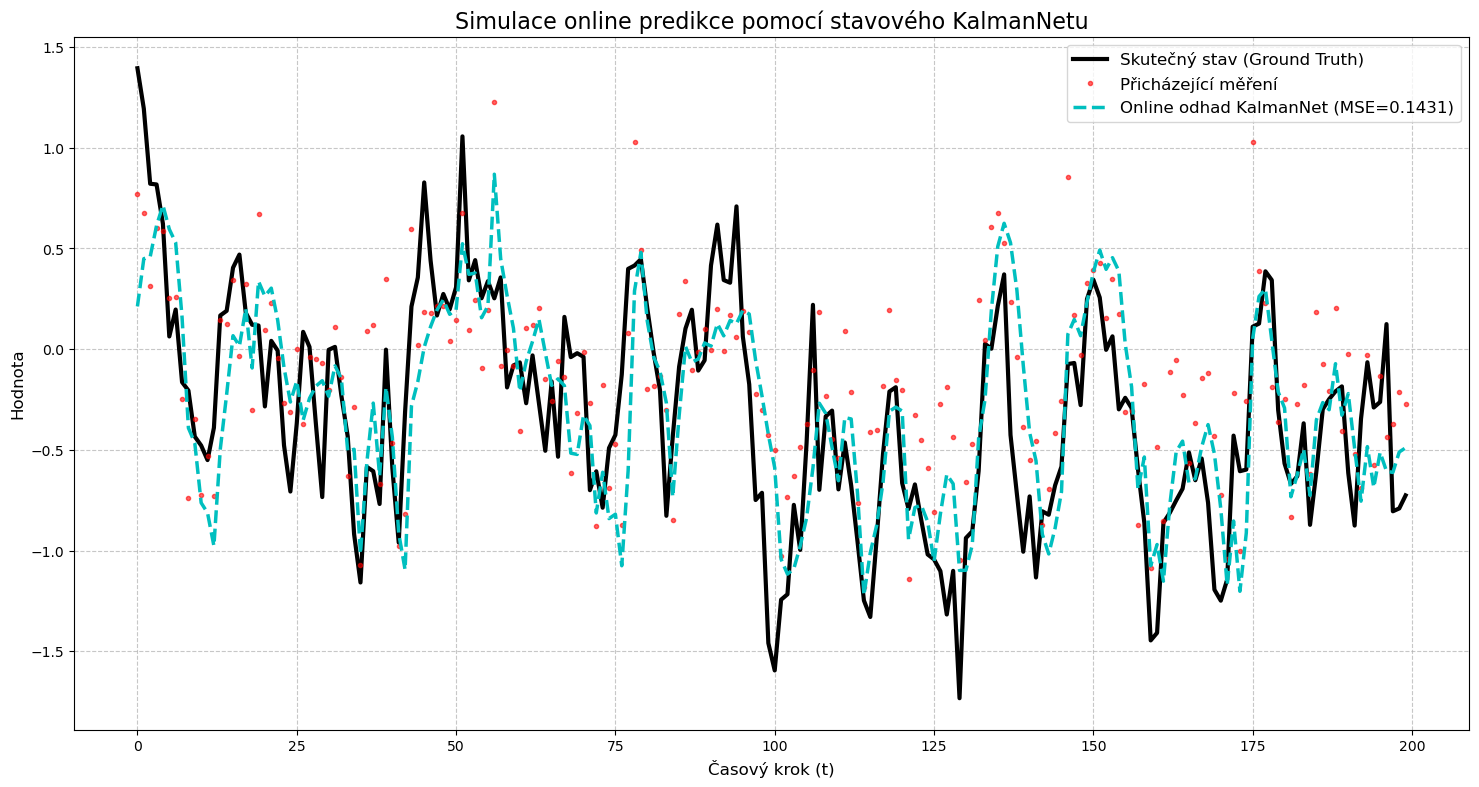

In [11]:
import torch
import matplotlib.pyplot as plt
import time
import numpy as np

x_online_test, y_online_test = utils.generate_data(sys_true, num_trajectories=1, seq_len=TEST_SEQ_LEN)

y_online_seq = y_online_test.squeeze(0).to(device) # Tvar [seq_len, obs_dim]
x_true_seq = x_online_test.squeeze(0).cpu()      # Tvar [seq_len, state_dim]

# --- 2. Simulace online filtrace ---
state_knet.eval()

# DŮLEŽITÉ: Reset vnitřního stavu filtru na začátku
state_knet.reset(batch_size=1)

# Seznam pro sběr online odhadů
online_predictions = []
# Seznam pro měření času na jeden krok
step_times = []

with torch.no_grad():
    for t in range(TEST_SEQ_LEN):
        
        start_time = time.time()
        
        y_t = y_online_seq[t, :].unsqueeze(0)
        
        x_filtered_t = state_knet.step(y_t)
        
        end_time = time.time()
        step_times.append(end_time - start_time)
        
        online_predictions.append(x_filtered_t.cpu().squeeze(0))

print("Online simulace dokončena.")

x_hat_online = torch.stack(online_predictions, dim=0)

mse_online = F.mse_loss(x_hat_online, x_true_seq)
avg_step_time_ms = np.mean(step_times) * 1000 # Průměrný čas v milisekundách

print("\n--- Výsledky online simulace ---")
print(f"  Celková MSE: {mse_online.item():.4f}")
print(f"  Průměrný čas na jeden krok filtrace: {avg_step_time_ms:.4f} ms")


plt.figure(figsize=(18, 9))
plt.title("Simulace online predikce pomocí stavového KalmanNetu", fontsize=16)

x_true_plot = x_true_seq.numpy()
y_meas_plot = y_online_seq.cpu().numpy()
x_hat_online_plot = x_hat_online.numpy()

plt.plot(x_true_plot, 'k-', linewidth=3, label="Skutečný stav (Ground Truth)")
plt.plot(y_meas_plot, 'r.', markersize=6, alpha=0.6, label="Přicházející měření")
plt.plot(x_hat_online_plot, 'c--', linewidth=2.5, label=f"Online odhad KalmanNet (MSE={mse_online.item():.4f})")

plt.xlabel("Časový krok (t)", fontsize=12)
plt.ylabel("Hodnota", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show()